In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prelim

### Manual DataFrame

In [9]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )

In [10]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### word itos

In [11]:
freq = Counter(df.word)
min_freq = 1

itos = [o for o,c in freq.most_common() if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
itos.insert(3, '_eos_')
len(itos)

5902

In [12]:
word_itos = itos

In [13]:
pickle.dump(word_itos, open(TMP_PATH/'synth_word_itos.pkl', 'wb'))

### Convert synth_words.csv to word_ids

In [14]:
# this is specific to synth_words.csv
# char_itos = pickle.load(open(TMP_PATH/'synth_char_itos.pkl', 'rb'))
char_itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

#### Convert char_ids -> words -> word_ids

In [16]:
CSV = PATH/'synth_words_50000.csv'
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...


In [24]:
res = [''.join([char_itos[int(c)] for c in line[:-2].split(' ')]) for line in csv.char_ids]

In [25]:
csv['words'] = res
csv.head()

,filename,char_ids,words
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3,most people disc
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...,them occurs dried
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...,delight reasonably could
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3,they after ready
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...,chosen alarmed authority


In [26]:
joined_labels = list(csv.words)

word_stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(word_itos)})
ids = np.array([np.array([word_stoi[word] for word in line.split(' ')]+[3]) for line in joined_labels])

In [27]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [28]:
csv['word_ids'] = str_ids
csv.head()

,filename,char_ids,words,word_ids
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3,most people disc,49 38 2597 3
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...,them occurs dried,22 5524 1904 3
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...,delight reasonably could,4731 1572 27 3
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3,they after ready,13 66 716 3
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...,chosen alarmed authority,1455 4242 849 3


#### modify filenames to fit existing data structure

In [157]:
res = ['{:04d}'.format(i)+'.png' for i in range(10000)]

['9995.png', '9996.png', '9997.png', '9998.png', '9999.png']

In [159]:
csv['filename'] = res

### Convert multi_synth_words.csv to word_ids

In [12]:
res = [''.join([itos[int(c)] for c in line[:-2].split(' ')]) for line in csv.char_ids]

In [14]:
csv['words'] = res
csv.head()

,filename,char_ids,words
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...,lace- death four warily considerably without
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...,food twentieth Western been proved Rhodesia
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...,task choice being longshore which childless
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...,advisers that GENERAL were false example
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...,especially That step rolls know been


In [15]:
joined_labels = list(csv.words)

word_stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(w_itos)})
ids = np.array([np.array([word_stoi[word] for word in line.split(' ')]+[3]) for line in joined_labels])

In [16]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [17]:
csv['word_ids'] = str_ids
csv.head()

,filename,char_ids,words,word_ids
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...,lace- death four warily considerably without,2 277 129 2 4775 99 3
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...,food twentieth Western been proved Rhodesia,342 2 1311 9 523 327 3
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...,task choice being longshore which childless,1465 2094 23 2 6 1616 3
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...,advisers that GENERAL were false example,2412 4 4331 11 477 930 3
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...,especially That step rolls know been,735 106 949 2 56 9 3


In [18]:
W_CSV = PATH/'multi_synth_word_ids.csv'
csv.to_csv(W_CSV, columns=['filename', 'word_ids'], index=False)

### Convert synth_words.csv to char_itos format

In [ ]:
old_char_itos = pickle.load(open(TMP_PATH/'synth_char_itos.pkl', 'rb'))

In [87]:
res = [''.join([old_char_itos[int(c)] for c in line.split(' ')]) for line in char_csv.char_ids]

In [88]:
char_stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(char_itos)})
ids = np.array([np.array([char_stoi[char] for char in list(line)]+[3]) for line in res])

In [89]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [90]:
char_csv['char_ids'] = str_ids
char_csv.head()

,filename,char_ids
0,000.png,71 73 70 71 60 73 1 64 69 61 56 75 76 56 75 64...
1,001.png,56 74 74 76 68 71 75 64 70 69 1 56 76 75 76 68...
2,002.png,78 63 60 73 60 1 57 60 58 70 68 60 1 71 60 73 ...
3,003.png,64 69 61 70 73 68 56 75 64 70 69 1 74 70 68 60...
4,004.png,62 73 60 56 75 60 74 75 1 75 60 67 67 1 74 75 ...


#### modify filenames to fit existing data structure

In [91]:
res = ['{:04d}'.format(i)+'.png' for i in range(10000)]

In [92]:
char_csv['filename'] = res
char_csv.head()

,filename,char_ids
0,0000.png,71 73 70 71 60 73 1 64 69 61 56 75 76 56 75 64...
1,0001.png,56 74 74 76 68 71 75 64 70 69 1 56 76 75 76 68...
2,0002.png,78 63 60 73 60 1 57 60 58 70 68 60 1 71 60 73 ...
3,0003.png,64 69 61 70 73 68 56 75 64 70 69 1 74 70 68 60...
4,0004.png,62 73 60 56 75 60 74 75 1 75 60 67 67 1 74 75 ...


### Convert multi_synth_words.csv to char_itos format

In [10]:
old_char_itos = pickle.load(open(TMP_PATH/'multi_synth_itos.pkl', 'rb'))

In [12]:
res = [''.join([old_char_itos[int(c)] for c in line.split(' ')]) for line in csv.char_ids]

In [46]:
stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[char] for char in list(line)]+[3]) for line in res])

In [47]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [48]:
csv['char_ids'] = str_ids
csv.head()

,filename,char_ids
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...


In [53]:
csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

# Helper Functions

In [5]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

In [7]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

### 3x1

In [8]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'
# char_csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

10000

In [9]:
seq_len = 45

### 3x2

In [8]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [9]:
seq_len = 75

### Large (1000x1000)

In [8]:
CSV = PATH/'large_synth_words.csv'
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

5000

In [9]:
seq_len = 200

### Word

In [7]:
w_itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [8]:
W_CSV = PATH/'multi_synth_word_ids.csv'
FOLDER = 'multi_synth_words'
# csv.to_csv(CSV, columns=['filename', 'word_ids'], index=False)

w_csv = pd.read_csv(W_CSV)
len(w_csv)

50000

#### Only word testing

In [9]:
itos = w_itos
CSV = W_CSV
csv = w_csv
seq_len = 8

### Get val_idxs

In [10]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### Calculate normalization stats

In [16]:
means = []
stds  = []
for filename in os.listdir(PATH/FOLDER):
    im=Image.open(PATH/FOLDER/filename)
    img = np.array(im)
    means.append(img.mean((0,1)))
    stds.append(img.std((0,1)))
    im.close()
    
means = np.stack(means)
stds = np.stack(stds)

In [57]:
stats = (np.array(means.mean(0)/255), np.array(stds.mean(0)/255))
stats

(array([0.90382, 0.90382, 0.90382]), array([0.19798, 0.19798, 0.19798]))

### ModelData object

In [11]:
f = resnet34
sz = 64
bs = 120

# sz = 256
# bs = 20

In [12]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# resizes in the transforms
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)
# loads in the data at full size

In [13]:
# this saves a bit of memory
data = data.resize(256)

In [14]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify dataset transforms

In [15]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
imgs = denorm(x)

In [16]:
# check image normalization
reshaped = x.permute(1,0,2,3).contiguous().view(3,-1)
trn_mean = reshaped.mean(1)
trn_std  = reshaped.std(1)
print(f"mean: {trn_mean}\nstd: {trn_std}")

mean: tensor([-0.0328, -0.0328, -0.0328], device='cuda:0')
std: tensor([0.8205, 0.8205, 0.8205], device='cuda:0')


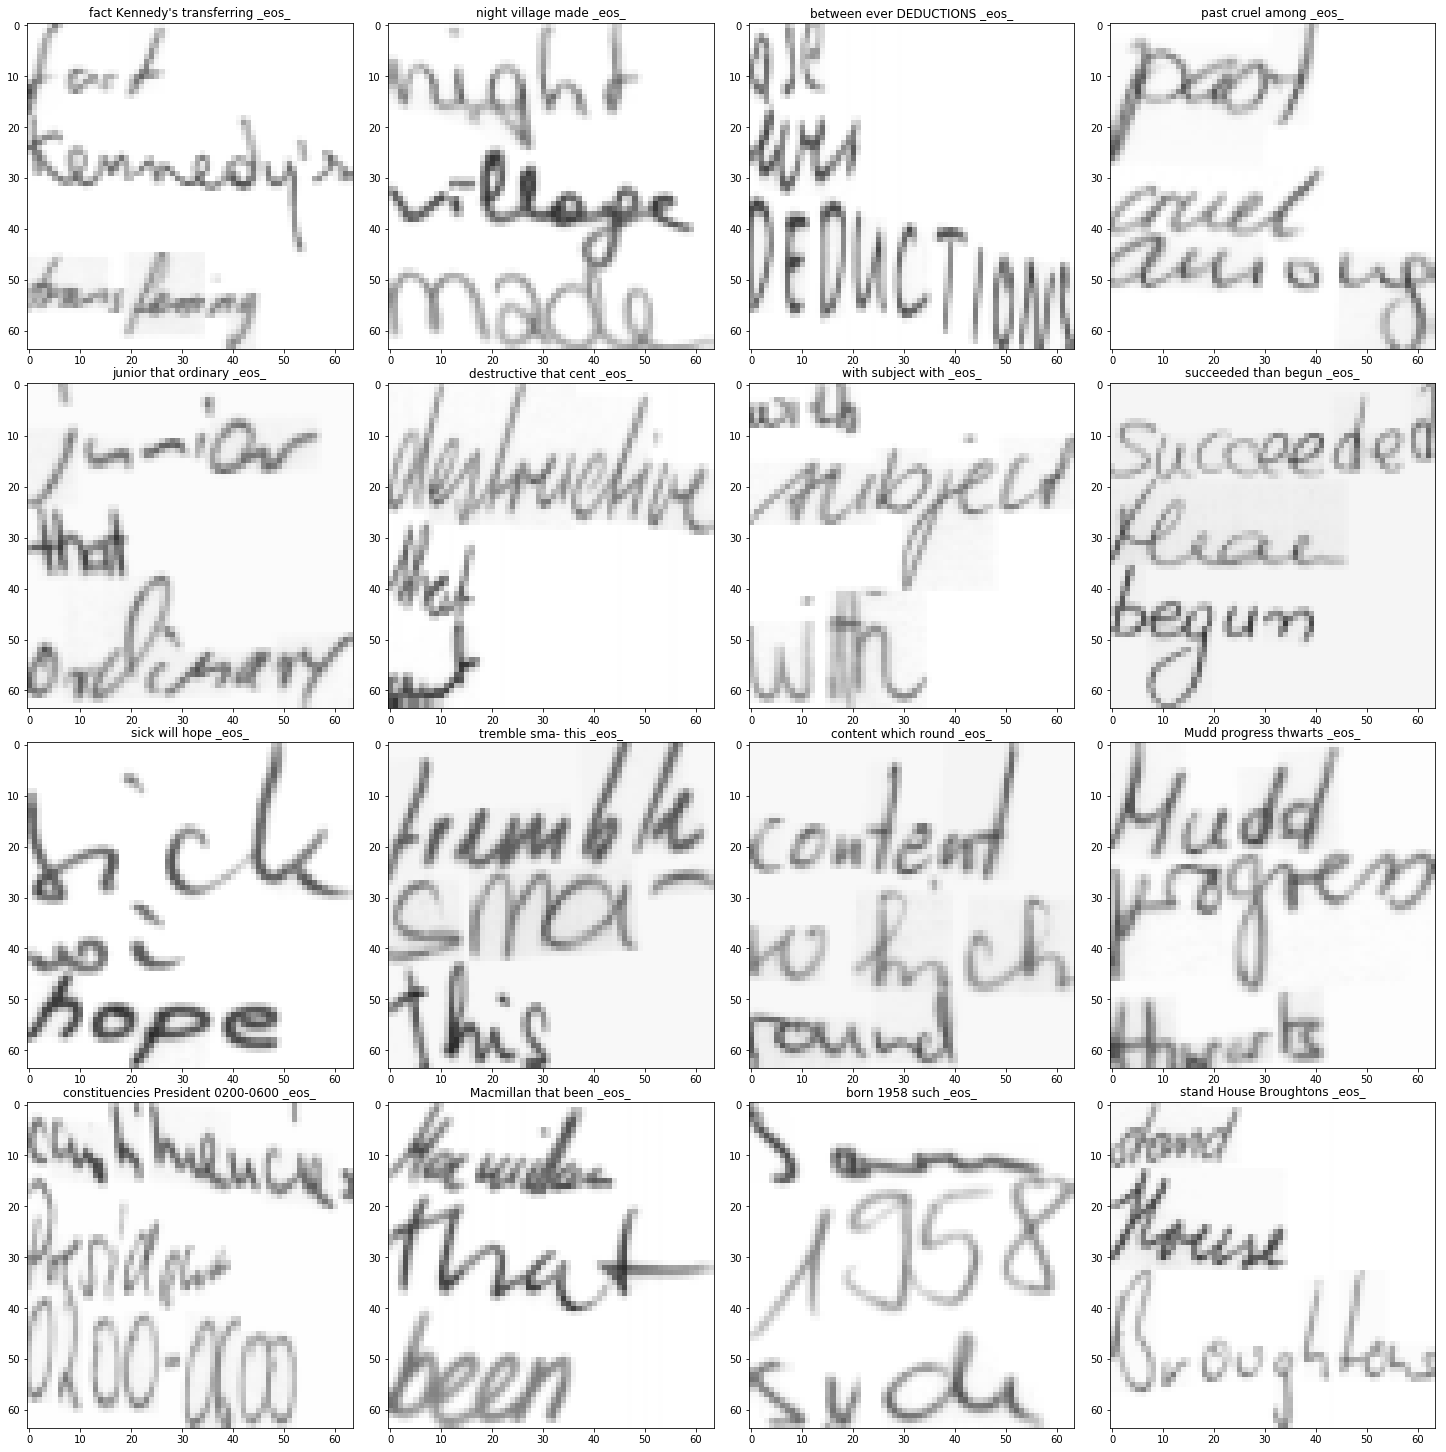

In [17]:
fig, axes = plt.subplots(4,4, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Combine word/char datasets

In [16]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [17]:
w_data = ImageClassifierData.from_csv(PATH, FOLDER, W_CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [18]:
trn_ds = ConcatLblDataset(data.trn_ds, w_data.trn_y)
val_ds = ConcatLblDataset(data.val_ds, w_data.val_y)
data.trn_dl.dataset = trn_ds
data.val_dl.dataset = val_ds

In [19]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify multi-dataset

In [20]:
denorm = data.trn_ds.ds.denorm   # need the extra .ds when using ConcatLblDataset
_,(y0,y1) = next(iter(data.trn_dl))

In [21]:
chars = [itos[int(w)] for w in y0[3]]
''.join(chars)

'Tuesday little they that Above called_eos__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad_'

In [22]:
words = [w_itos[int(c)] for c in y1[3]]
' '.join(words)

'Tuesday little they that Above called _eos_'

# Loss and Metrics

In [15]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [16]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [17]:
def error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def word_error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ' '.join([w_itos[i] for i in ints])

def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_error_label(res[:,i])
        t = word_error_label(targs[i])
        error += wer(t,p)
    return error/bs

### CTC

In [19]:
from warpctc_pytorch import CTCLoss

ctc = CTCLoss(size_average=True)    #normalize loss by batch size

def ctc_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size() 
    
    inp_lens = torch.full((bs,), sl, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[:,i]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
        
    return ctc(input, targ, inp_lens, targ_lens)
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

### Combo word/char

In [59]:
def char_error(preds, targs):
    c_preds,_ = preds
    c_targs,_ = targs
    
    bs,sl = c_targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(c_preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(c_targs[i])
        error += cer(t,p)
    return error/bs

def word_error(preds, targs):
    _,w_preds = preds
    _,w_targs = targs
    
    bs,sl = w_targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(w_preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_error_label(res[:,i])
        t = word_error_label(w_targs[i])
        error += wer(t,p)
    return error/bs/sl

In [39]:
def combo_loss(preds, targs):
    char_loss = ctc_loss(preds[0], targs[0])
    word_loss = seq2seq_loss(preds[1], targs[1])
    return char_loss + word_loss.cpu()

# Arch

In [51]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [74]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [75]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [76]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [77]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.5):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [78]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

 42%|████▏     | 150/355 [00:50<01:08,  2.98it/s, loss=388]

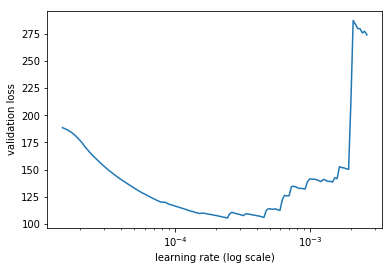

In [58]:
learn.lr_find()
learn.sched.plot()

In [79]:
# lr=1e-4
# learn.fit(lr, 3, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))

lr=1e-3
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))

# 68.923135  68.804574  0.778221     arch, sz:96, lr:1e-4
# 70.384609  70.11158   0.853604     "", sz: 64, lr:1e-4, clr_beta, feature slice based on sz

# 65.013099  64.089046  0.744029     "", sz: 64, lr:1e-3, clr, feature slice based on sz
# 65.116957  63.882609  0.742186     "", sz: 64, lr:1e-3, clr, feature slice based on sz, dropout

epoch      trn_loss   val_loss   char_error_rate            
    0      70.503348  70.299874  0.806128  
    1      68.23545   67.674061  0.787044                   
    2      65.116957  63.882609  0.742186                   


[63.88260862562392, 0.7421860706910671]

# Arch mod

In [21]:
# modified for sz: 64

class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()
        
#         slices = {128: -4, 256: -3, 512: -2}
#         s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:-4]    #(8,8,128)  sz: 64
        self.base = nn.Sequential(*modules)
        
        self.linear0 = nn.Linear(128, embed_size)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp).flatten(2, 3).permute(2, 0, 1)
        features = self.linear0(features)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [22]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [23]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, dropout=drop)

    def forward(self, context, hidden):
        out, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return out[-1]

In [24]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [25]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [26]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

In [30]:
# lr=1e-4
# learn.fit(lr, 3, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))

lr=1e-3
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))

# 3x1, sz: 64, sl: 45
# 68.923135  68.804574  0.778221     sz:96, lr:1e-4
# 70.384609  70.11158   0.853604     sz: 64, lr:1e-4 clr_beta, slice: -4    **sz most imp for attn!
# 65.013099  64.089046  0.744029     "", lr:1e-3 clr, ""
# 65.116957  63.882609  0.742186     "", "", "", dropout
# 66.724635  65.784025  0.750741     "", "", "", "", init_hidden            **hidden doesn't make a big difference
# 67.904225  66.286942  0.768866     "", "", "", "", simplified deep output
# 67.210914  68.855696  0.6979 ?     "", "", "", "", mod deep output
# 63.62897   61.755674  0.716586     "", "", "", "", 2 layers
# 63.363833  61.547648  0.726961     "", "", "", "", 2 layers w/ dropout
# 65.447725  64.916475  0.745606     "", "", "", "", 2 layers w/ dropout bidir
# 66.733563  65.220792  0.725245     "", "", "", "", 1 layer bidir
# 61.781128  58.316876  0.671617     "", "", "", "", 3 layers w/ dropout     ***
# 66.353612  65.012771  0.742848     "", "", "", "", 3 layers w/ dropout, uniform embedding weights
# 66.892848  65.19859   0.747121     "", "", "", "", 3 layers w/ dropout, Embedding

# 60.088251  56.6687    0.64367      3 layers w/ dropout; data specific normalization stats    ***
# 51.163667  48.662667  0.517828     2nd run
# 44.073406  43.868489  0.413981     3rd run

# 3x2, sz: 128, sl: 75
# 134.990034 134.306841 0.831486     lr: 1e-3, slice: -4

epoch      trn_loss   val_loss   char_error_rate            
    0      48.504199  47.054292  0.471103  
    1      46.739694  45.966555  0.43901                    
    2      44.073406  43.868489  0.413981                   



[43.868489098927334, 0.41398064245362093]

In [31]:
learn.save('experiment')

## Increase size - 128

In [32]:
sz = 128
bs = 100

In [36]:
learn.set_data(data)

In [ ]:
lr = 1e-3
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# (3x1)
# 60.088251  56.6687    0.64367      3 layers w/ dropout; data specific normalization stats    ***

epoch      trn_loss   val_loss   char_error_rate            
    0      39.609307  35.663588  0.31555   
    1      35.746859  32.165946  0.264416                   
 79%|███████▉  | 337/425 [02:40<00:41,  2.10it/s, loss=36.1]

# Arch word LM

In [19]:
# modified for sz: 64

class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()
        
#         slices = {128: -4, 256: -3, 512: -2}
#         s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())  #[:6]    #(8,8,128)  sz: 64
        self.base = nn.Sequential(*modules[:6])
        self.linear0 = nn.Linear(128, embed_size)
        
        self.convs = nn.Sequential(*modules[6:8])
        self.linear1 = nn.Linear(512, embed_size)
        self.pool = nn.AdaptiveMaxPool1d(3)
                
        #mlp
        self.drop = nn.Dropout(drop)
#         self.linear1 = nn.Linear(embed_size, embed_size)
#         self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        base = self.drop(self.base(inp))
        features = self.linear0(base.flatten(2, 3).permute(2, 0, 1))
        
        h = self.convs(base)
        h = self.pool(h.flatten(2,3)).permute(2,0,1)
        h = self.linear1(h)
        # initial hidden is an average of features fed through an MLP
#         h = self.drop(features)
#         h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [20]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                                        # ([64, bs, 256])
        w2h = self.attn_2(hidden)                                       # ([3, bs, 256])
        u = self.drop(torch.tanh(w1e.unsqueeze(0) + w2h.unsqueeze(1)))  # ([3, 64, bs, 256])
        a = torch.softmax(u @ self.attn_v, -1)                          # ([3, 64, bs]) - attention mask
        context = (a.unsqueeze(-1) * feats.unsqueeze(0)).sum(1)         # ([3, bs, 256]) - weighted sum of features
        
        return context, a

In [32]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, dropout=drop)

    def forward(self, context, hidden):
        out, h = self.rnn(context, hidden.mean(0).expand(self.num_layers, -1, -1).contiguous())
        
        return out

In [28]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], -1)
        
        return self.w3(self.drop(out))

In [33]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones((3, bs), device=device).long()
        
        for i in range(15):
            prev = self.embed(dec_inp)  # word embedding
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = torch.argmax(out, dim=-1)
            
        res = torch.stack(res).flatten(0,1).contiguous()
        if ret_attn: res = res,torch.stack(attns).flatten(0,1)
        return res

In [34]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = ctc_loss
learn.metrics = [char_error_rate]

In [37]:
lr=1e-3
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))

# 52.665683  49.088483  0.754987    w/ deep output
# 41.981947  38.029764  0.719204    2nd run
# 35.092354  30.711854  0.708282    3rd run

epoch      trn_loss   val_loss   char_error_rate            
    0      40.197421  35.299999  0.769188  
    1      37.469083  32.957971  0.492925                   
    2      35.092354  30.711854  0.708282                   



[array([30.71185]), 0.7082816717008937]

In [38]:
learn.save('3x1_parallel')

# Parallel Char Arch

In [18]:
class Encoder(nn.Module):
    def __init__(self, embed_size, num_words, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        self.pool = nn.AdaptiveMaxPool1d(16)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, num_words)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3)
        
        # initial hidden is an average of features fed through an MLP
        h = self.pool(self.drop(features))
        h = self.linear2(F.relu(self.linear1(h)))
                        
        return features.permute(0, 2, 1), h.permute(2, 0, 1)

In [19]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        num,bs,em_sz = hidden.shape
        w1e = self.attn_1(feats)                    # ([bs, 64, 256])
        w2h = self.attn_2(hidden)                   # ([3, bs, 256])
        u = self.drop(torch.tanh(w1e.unsqueeze(0) + w2h.unsqueeze(2)))        # ([3, bs, 64, 256])
        u = u.view(num*bs, -1, em_sz)               
        a = torch.softmax(u @ self.attn_v, 1)       # ([3*bs, 64]) - attention mask
        a = a.view(num, bs, -1)
        context = (a.unsqueeze(-1) * feats.unsqueeze(0)).sum(2)   # ([3, bs, 256]) - weighted sum of features w/ attention
        
        return context, a

In [20]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, drop=0.3):
        super().__init__()
        
        self.rnn = nn.GRU(embed_size, embed_size)

    def forward(self, context, hidden):
        # num, bs, em_sz
        out, h = self.rnn(context, hidden.mean(0)[None])
        
        return out

In [21]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
#         self.w0 = nn.Linear(embed_size, embed_size)
#         self.w1 = nn.Linear(embed_size, embed_size)
#         self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, embed_size)
        self.w4 = nn.Linear(embed_size*3, embed_size)
        self.drop = nn.Dropout(drop)
        self.w5 = nn.Linear(embed_size, vocab_size)
        
    def forward(self, prev, hidden, context):
        #=> ([bs, 256])
#         a = self.w0(prev)
#         b = self.w1(hidden)
#         c = self.w2(context)
        cat = torch.cat([prev,hidden,context], -1)
        ig = torch.sigmoid(self.w3(self.drop(cat)))
        og = self.w4(cat)        
        
        return self.w5(og * ig)

In [22]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, num_words, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.num_words = num_words
        
        self.encoder = Encoder(hidden_size, num_words)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
                
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones((self.num_words, bs), device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.argmax(-1)
            
        res = torch.stack(res)    #sl,num,bs,vocab
        res = res.view(self.seq_len*self.num_words, bs, -1).contiguous()
        
        if ret_attn: res = res,torch.stack(attns)
        return res

In [23]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 15, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Conv Seq2seq Arch

In [16]:
def Conv1d(in_channels, out_channels, kernel_size, dropout=0, **kwargs):
    """Weight-normalized Conv1d layer"""
    m = nn.Conv1d(in_channels, out_channels, kernel_size, **kwargs)
    std = math.sqrt((4 * (1.0 - dropout)) / (m.kernel_size[0] * in_channels))
    nn.init.normal_(m.weight, mean=0, std=std)
    nn.init.constant_(m.bias, 0)
    return nn.utils.weight_norm(m, dim=2)

def Linear(in_features, out_features, dropout=0):
    """Weight-normalized Linear layer (input: N x T x C)"""
    m = nn.Linear(in_features, out_features)
    nn.init.normal_(m.weight, mean=0, std=math.sqrt((1 - dropout) / in_features))
    nn.init.constant_(m.bias, 0)
    return nn.utils.weight_norm(m)

def Embedding(num_embeddings, embedding_dim, padding_idx=0):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, 0, 0.1)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m

class GradMultiply(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale):
        ctx.scale = scale
        res = x.new(x)
        return res

    @staticmethod
    def backward(ctx, grad):
        return grad * ctx.scale, None

In [17]:
class ConvLayer(nn.Module):
    def __init__(self, embed_size, k, drop=0.2):
        super().__init__()
        
        self.drop = nn.Dropout(drop)
        
        padding = k // 2 if (k % 2 == 1) else 0   # maintain size w/ appropriate padding
        self.conv = Conv1d(embed_size, embed_size*2, k, dropout=drop, padding=padding)

    def forward(self, x):
        x = F.glu(self.conv(self.drop(x)), dim=1)
        return x

In [18]:
class InputEmbedding(nn.Module):
    def __init__(self, embed_size, drop=0.2):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.drop(self.base(x).flatten(2, 3))
        return x

In [19]:
class Encoder(nn.Module):
    def __init__(self, embed_size, num_layers, num_dec_layers, drop=0.2):
        super().__init__()
        
        self.num_dec_layers = num_dec_layers
        
        self.convs = nn.ModuleList()
        for l in range(num_layers):
            self.convs.append(ConvLayer(embed_size,3,drop))
        
    def forward(self, input_embedding):
        x = input_embedding
        
        for conv in self.convs:
            residual = x
            x = conv(x)
            x = (x + residual) * math.sqrt(0.5)
            
        # scale gradients (this only affects backward, not forward)
        x = GradMultiply.apply(x, 1.0 / (2.0 * self.num_dec_layers))
        
        # add final output to input embedding for attention
        x = (x + input_embedding) * math.sqrt(0.5)
        
        return x   #=> ([bs, em_sz, 16])

In [22]:
class ConvAttention(nn.Module):
    def __init__(self):
        super().__init__()
                
    def forward(self, x, target_embedding, encoder_out):
        residual = x
                
        x = (x + target_embedding) * math.sqrt(0.5)
        x = torch.bmm(x.permute(0, 2, 1), encoder_out[0])

        # softmax over last dim
        x = F.softmax(x, dim=-1)                            #=> ([bs, targ_len, src_len])
        attn_scores = x

        x = torch.bmm(x, encoder_out[1].permute(0, 2, 1))   #=> ([bs, targ_len, em_sz])

        # scale attention output by src_len (respecting potentially different lengths)
        s = encoder_out[1].size(-1)
        x = x * (s * math.sqrt(1.0 / s))
        
        x = x.permute(0, 2, 1)

        x = (x + residual) * math.sqrt(0.5)
        return x, attn_scores

In [23]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers, vocab_size, drop=0.2):
        super().__init__()
        
#         self.embed = Embedding(vocab_size, embed_size)

        self.convs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        
        for l in range(num_layers):
            self.convs.append(ConvLayer(embed_size,3,drop))
            self.attentions.append(ConvAttention())
        
    def forward(self, target_embedding, encoder_out):
#         target_embedding = self.embed(target.long())        # convert floats => idxs   ([bs, 32, em_sz])
#         target_embedding = target_embedding.permute(0,2,1)  # match encoder out shapes ([bs, em_sz, 32])
        x = target_embedding
        
        attn_scores = None
        for conv,attention in zip(self.convs, self.attentions):
            residual = x
            x = conv(x)            
            x, attn_scores = attention(x, target_embedding, encoder_out)
            x = (x + residual) * math.sqrt(0.5)  # this must be before attn for training to progress

        return x, attn_scores

In [24]:
class Net(nn.Module):
    def __init__(self, embed_size, vocab_size, seq_len, enc_layers=3, dec_layers=3, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.features = InputEmbedding(embed_size)
        self.linear   = Linear(sz//4, seq_len)
        
        self.encoder = Encoder(embed_size, enc_layers, dec_layers)
        self.decoder = Decoder(embed_size, dec_layers, vocab_size)

        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = Linear(embed_size, embed_size//2)
        self.linear2 = Linear(embed_size//2, vocab_size)
        
    def forward(self, x, targets=None, ret_attn=False):
        bs = x.size(0)
        feats = self.features(x)

        x = self.encoder(feats)       #=> ([bs, em_sz, 16])
        targets = self.linear(feats)
        
#         targets = torch.ones((bs, self.seq_len), device=device) if targets is None else targets
        x, a = self.decoder(targets, x)     #=> ([120, 256, 31]), ([120, 31, 16])
        
        x = self.linear2(F.relu(self.drop(self.linear1( x.permute(0,2,1) ))))  #=> (bs, sl, vocab)

        # loss expects sl,bs,vocab
        x = x.permute(1,0,2).contiguous()
        return x,a if ret_attn else x

In [23]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 45)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Simplified Conv Seq2seq Arch

In [56]:
def Conv1d(in_channels, out_channels, kernel_size, dropout=0, **kwargs):
    """Weight-normalized Conv1d layer"""
    m = nn.Conv1d(in_channels, out_channels, kernel_size, **kwargs)
    std = math.sqrt((4 * (1.0 - dropout)) / (m.kernel_size[0] * in_channels))
    nn.init.normal_(m.weight, mean=0, std=std)
    nn.init.constant_(m.bias, 0)
    return nn.utils.weight_norm(m, dim=2)

def Linear(in_features, out_features, dropout=0):
    """Weight-normalized Linear layer (input: N x T x C)"""
    m = nn.Linear(in_features, out_features)
    nn.init.normal_(m.weight, mean=0, std=math.sqrt((1 - dropout) / in_features))
    nn.init.constant_(m.bias, 0)
    return nn.utils.weight_norm(m)

def Embedding(num_embeddings, embedding_dim, padding_idx=0):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, 0, 0.1)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m

class GradMultiply(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale):
        ctx.scale = scale
        res = x.new(x)
        return res

    @staticmethod
    def backward(ctx, grad):
        return grad * ctx.scale, None

In [57]:
class ConvLayer(nn.Module):
    def __init__(self, embed_size, k, drop=0.2):
        super().__init__()
        
        self.drop = nn.Dropout(drop)
        
        padding = k // 2 if (k % 2 == 1) else 0   # maintain size w/ appropriate padding
        self.conv = Conv1d(embed_size, embed_size*2, k, dropout=drop, padding=padding)

    def forward(self, x):
        x = F.glu(self.conv(self.drop(x)), dim=1)
        return x

In [58]:
class BaseResnet(nn.Module):
    def __init__(self, embed_size, drop=0.2):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.drop(self.base(x).flatten(2, 3))
        return x

In [59]:
class Encoder(nn.Module):
    def __init__(self, embed_size, num_layers, num_dec_layers, drop=0.2):
        super().__init__()
        
        self.num_dec_layers = num_dec_layers
        
        self.convs = nn.ModuleList()
        for l in range(num_layers):
            self.convs.append(ConvLayer(embed_size,3,drop))
        
    def forward(self, input_embedding):
        x = input_embedding
        
        for conv in self.convs:
            residual = x
            x = conv(x)
            x = (x + residual) * math.sqrt(0.5)
            
        # scale gradients (this only affects backward, not forward)
        x = GradMultiply.apply(x, 1.0 / (2.0 * self.num_dec_layers))
        
        # add final output to input embedding for attention
        x = (x + input_embedding) * math.sqrt(0.5)
        
        return x   #=> ([bs, em_sz, 16])

In [60]:
class ConvAttention(nn.Module):
    def __init__(self):
        super().__init__()
                        
    def forward(self, hidden, feats):
        
        x = torch.bmm(hidden.permute(0, 2, 1), feats)

        x = F.softmax(x, dim=-1)                            #=> ([bs, targ_len, src_len])
        attn_scores = x

        x = torch.bmm(x, feats.permute(0, 2, 1))            #=> ([bs, targ_len, em_sz])
        
        x = x.permute(0, 2, 1)                              #=> ([bs, em_sz, targ_len])

        return x, attn_scores

In [61]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers, vocab_size, drop=0.2):
        super().__init__()
        
        self.convs = nn.ModuleList()
        for l in range(num_layers):
            self.convs.append(ConvLayer(embed_size,3,drop))
        
    def forward(self, target_embedding):
        x = target_embedding
        
        for conv in self.convs:
            residual = x
            x = conv(x)            
            x = (x + residual) * math.sqrt(0.5)
           
        x = (x + target_embedding) * math.sqrt(0.5)
        
        return x

In [62]:
class Net(nn.Module):
    def __init__(self, embed_size, vocab_size, seq_len, enc_layers=3, dec_layers=3, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.features = BaseResnet(embed_size)   #sz: 16->256, seq_len: 50->500
        self.pool     = nn.AdaptiveMaxPool1d(seq_len)
        
        self.encoder = Encoder(embed_size, enc_layers, dec_layers)
        
        self.attention = ConvAttention()
        
        self.decoder = Decoder(embed_size, dec_layers, vocab_size)

        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = Linear(embed_size, embed_size//2)
        self.linear2 = Linear(embed_size//2, vocab_size)
        
    def forward(self, x, ret_attn=False):
        feats = self.features(x)
        
        x = self.encoder(feats)       #=> ([bs, em_sz, 16])
        x = self.pool(x)              #=> ([bs, em_sz, 45])
        
        context, a = self.attention(x, feats)

        x = self.decoder(context)     #=> ([bs, em_sz, seq_len])
        
        x = self.linear2(F.relu(self.drop(self.linear1( x.permute(0,2,1) ))))  #=> (bs, sl, vocab)

        # loss expects sl,bs,vocab
        x = x.permute(1,0,2).contiguous()
        return x,a if ret_attn else x

In [63]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Attend and Rectify

In [111]:
class Conv(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=3):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, padding=k//2, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight.data)

    def forward(self, x):
        return self.conv(x).flatten(2,3)

In [94]:
class MultiHeadAttention(nn.Module):
    def __init__(self, nf, labels, seq_len, parent, drop=0.1):
        super().__init__()
        self.outs = parent.outs
        self.nheads = 3
        self.labels = labels
        
        self.head = Conv(nf, self.nheads, 3, padding=1)
        self.out = Conv(nf, labels*self.nheads, 3, padding=1)
        self.seq = Conv(nf, seq_len, 3, padding=1) 
                
    def forward(self, x):
        bs, c, h, w = x.size()
        
        mask = torch.softmax(self.head(x).flatten(2,3).unsqueeze(2), dim=-1)
        out = (self.out(x).view(bs, self.nheads, self.labels, h*w) * mask).sum(1)  # sum over heads        
        seq = self.seq(x).flatten(2,3)
        probs = torch.bmm(seq, out.permute(0, 2, 1))

        self.outs.append(probs)
        return x

class SingleHeadAttention(nn.Module):
    def __init__(self, nf, labels, seq_len, drop=0.1):
        super().__init__()

        self.out = Conv(nf, labels, 3)
        self.seq = Conv(nf, seq_len, 3) 
                
    def forward(self, x):        
        out = torch.tanh(self.out(x))                       #=> ([bs, vocab, h*w])
        seq = torch.tanh(self.seq(x))                       #=> ([bs, seq_len, h*w])
        
        mask = F.softmax(seq, dim=-1)                       #=>  spatial attention mask over seq_len
        probs = torch.bmm(mask, out.permute(0, 2, 1))       #=> ([bs, seq_len, vocab])

        return probs

In [116]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, k=3, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, k, bias=False, stride=stride, padding=k//2)
        self.bn   = nn.BatchNorm2d(nf, momentum=0.01)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

    
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1 = ConvLayer(ni, ni//2, k=1)
        self.conv2 = ConvLayer(ni//2, ni, k=3)
        
    def forward(self, x):
        return x.add(self.conv2(self.conv1(x)))

    
class Block(nn.Module):
    def __init__(self, ni, nf, stride=2):
        super().__init__()
        
        self.conv = ConvLayer(ni, nf, stride=stride)
        self.res1 = ResLayer(nf)
        self.res2 = ResLayer(nf)
    
    def forward(self, x):
        return self.res2(self.res1(self.conv(x)))
        
        
class Darknet(nn.Module):
    def __init__(self, num_blocks, vocab_size, embed_size, seq_len, nf=32):
        super().__init__()

        self.layer1 = ConvLayer(3, 32, k=3, stride=1)
        self.block1 = Block(32, 64, 2)
        self.attn1  = SingleHeadAttention(64, vocab_size, seq_len)
        
        self.block2 = Block(64, 128, 2)
        self.attn2  = SingleHeadAttention(128, vocab_size, seq_len)

        self.block3 = Block(128, 256, 2)
        self.attn3  = SingleHeadAttention(256, vocab_size, seq_len)
        
    def forward(self, x):
        x = self.block1(self.layer1(x))
        out1 = self.attn1(x)
        x = self.block2(x)
        out2 = self.attn2(x)
        x = self.block3(x)
        out3 = self.attn3(x)

        out = torch.tanh(out1 + out2 + out3)

        # loss expects sl,bs,vocab
        out = out.permute(1,0,2).contiguous()
        return out

In [56]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Darknet([1, 2, 4, 1], len(itos), 256, seq_len, nf=32)
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Baseline - resnet/custom head

In [40]:
class Head(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()
        
        self.pool = nn.AdaptiveMaxPool1d(seq_len)
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc2(self.drop(F.relu(self.fc1(x))))
        return x.permute(1,0,2).contiguous()

In [25]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
head = Head(256, seq_len, len(itos))
net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = custom_loss #seq2seq_loss
learn.metrics = [word_error_rate] #[char_error_rate]

# Baseline word / gru char decoder

In [30]:
def base_resnet(em_sz):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    modules = list(net.children())[:s]
    return nn.Sequential(*modules)

class Encoder(nn.Module):
    def __init__(self, em_sz, vocab_size, seq_len, drop=0.2):
        super().__init__()

        self.enc  = base_resnet(em_sz)
        self.pool = nn.AdaptiveMaxPool1d(seq_len) 
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        feats = self.enc(x).flatten(2,3)
        h = self.pool(feats).permute(0,2,1)
        out = self.fc2(F.relu(self.fc1(self.drop(h))))
        return feats, h.flatten(0,1), out

In [31]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        bs, em_sz, hw = feats.shape
        
        feats = feats.permute(0,2,1).unsqueeze(1)   # bs, 1, h*w, em_sz
        hidden = hidden.view(bs, -1, 1, em_sz)      # bs, num, 1, em_sz

        w1e = self.attn_1(feats)                    # ([64, 30, 256])   # bs,1,h*w,em_sz
        w2h = self.attn_2(hidden)                   # ([30, 256])       # bs,num,1,em_sz
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])   # bs,num,h*w,em_sz
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, -1)      # ([64, 30]) - attention mask    # bs,num,h*w
        context = (a.unsqueeze(3) * feats).sum(2)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context.flatten(0,1), a              # (bs*num,em_sz),  (bs,num,h*w)

In [32]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, context, hidden):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [33]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.tanh(torch.cat([a,b,c], -1))
        
        return self.w3(self.drop(out)) 

In [40]:
class Net(nn.Module):
    def __init__(self, hidden_size, w_vocab, w_seq, c_vocab, c_seq, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.c_seq = c_seq
        self.w_seq = w_seq
        
        self.encoder = Encoder(hidden_size, w_vocab, w_seq)
        self.c_attn  = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(c_vocab, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, c_vocab)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden, words = self.encoder(x)       # (bs, em_sz, h*w), (bs*num, em_sz), (bs,w_seq,w_vocab)
                        
        chars,attns = [],[]
        dec_inp = torch.ones(bs*self.w_seq, device=device).long()
        
        for i in range(self.c_seq):
            context, a = self.c_attn(hidden, feats)   # (bs*num, em_sz)
            hidden = self.decoder(context, hidden)    # (bs*num, em_sz)
            prev = self.drop(self.embed(dec_inp))     # (bs*num, em_sz)
            
            out = self.output(prev, hidden, context)  # (bs*num, vocab)
            
            chars.append(out)
            attns.append(a)
            dec_inp = out.data.max(-1)[1]
            
        chars = torch.stack(chars).permute(1,0,2)   # bs*num,15,vocab
        chars = chars.view(bs, self.w_seq, self.c_seq, -1)
        chars = chars.flatten(1,2)                  # bs,seq,vocab
        
        chars = chars.permute(1,0,2).contiguous()       
        words = words.permute(1,0,2).contiguous()
        
        res = [chars,words]
        if ret_attn: res = res.append(torch.stack(attns))
        return res

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(w_itos), 8, len(itos), 15)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
# learn.crit = seq2seq_loss
learn.crit = combo_loss
learn.metrics = [char_error, word_error]

 52%|█████▏    | 221/425 [01:29<01:22,  2.48it/s, loss=209]

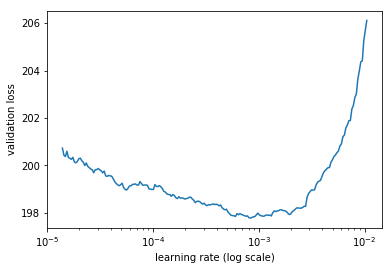

In [64]:
learn.lr_find()
learn.sched.plot()

In [67]:
lr=1e-3
learn.fit(lr, 3, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   char_error word_error     
    0      195.585222 198.734708 1.0        1.131371  
    1      194.659753 197.827848 1.0        1.0            
    2      193.806557 197.222208 1.0        1.0            


[array([197.22221]), 1.0, 1.0]

# Baseline w/ attention

In [52]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [65]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:s])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.base = base_resnet(em_sz, f)
        self.attention = Attention(em_sz)
        
        self.embed   = nn.Embedding(vocab_size, em_sz)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.fc_d = nn.Dropout(drop)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats = self.base(x).flatten(2,3).permute(2,0,1)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            context, a = self.attention(prev, feats)
            out = self.fc2(F.relu(self.fc1(self.fc_d(context))))
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [18]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, em_sz, drop=0.2):
        super().__init__()

        self.lin1 = nn.Linear(em_sz*2, em_sz)
        self.lin2 = nn.Linear(em_sz*2, em_sz)
        self.drop = nn.Dropout(drop)
        self.attn_v = rand_p(em_sz)
        
    def forward(self, feats, out): 
        f = self.lin1(feats.permute(0,2,1))        # bs,h*w,em_sz
        o = self.lin2(out.permute(0,2,1))          # bs,seq,em_sz
        
        u = torch.tanh(f.unsqueeze(1) + o.unsqueeze(2))
        u = self.drop(u)                                     # (bs, seq, h*w, em_sz)
        a = torch.softmax(u @ self.attn_v, 2)                # (bs, seq, h*w) - attention mask
        context = (a.unsqueeze(3) * f.unsqueeze(1)).sum(2)   # (bs, seq_len, em_sz)

        return context, a

In [27]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:s])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()

        self.base = base_resnet(em_sz, f)
        self.attn = Attention(em_sz, seq_len)
        
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        
        self.drop = nn.Dropout(drop)

    def forward(self, x, ret_attn=False):
        feats = self.base(x).flatten(2,3)     #bs,hidden,h*w
        out   = self.pool(feats)              #bs,hidden,seq
        out, attn = self.attn(feats, out)
        out = self.fc2(self.drop(F.relu(self.fc1(out))))
        out = out.permute(1,0,2).contiguous()
        if ret_attn: out = out,attn
        return out

In [66]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(256, seq_len, len(itos))
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

In [ ]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)

# 28.52144   27.718629  0.67499     attention
# 21.272572  20.69161   0.592019    2nd run

#       sequential attention; simple fc out

epoch      trn_loss   val_loss   word_error_rate            
    0      48.862049  49.671623  1.040457  
 28%|██▊       | 118/425 [00:34<01:28,  3.46it/s, loss=48.4]

In [35]:
learn.save('baseline_attn')

# Baseline - rnn

In [27]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:s])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()

        self.base = base_resnet(em_sz*2, f)
        self.pool = nn.Linearar(seq_len)

        self.rnn = nn.GRU(em_sz, em_sz)
        
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        
        self.drop = nn.Dropout(drop)

    def forward(self, x, ret_attn=False):
        feats = self.base(x).flatten(2,3)     #bs,hidden,h*w
        out   = self.pool(feats)              #bs,hidden,seq
        
        out, h = self.rnn(out.permute(2,0,1), out)
        
        out = self.fc2(self.drop(F.relu(self.fc1(out))))
        out = out.permute(1,0,2).contiguous()
        if ret_attn: out = out,attn
        return out

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(256, seq_len, len(itos))
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

In [ ]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)



# Train - Words

 50%|█████     | 213/425 [01:23<01:23,  2.54it/s, loss=155] 

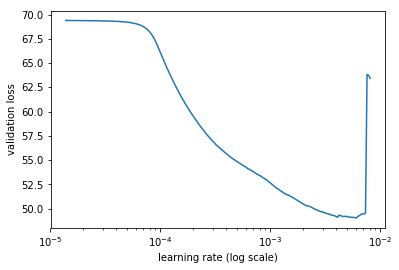

In [37]:
learn.lr_find()
learn.sched.plot()

In [27]:
lr=4e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)

# (3x2) sz:128, 50,000
# 15.190993  13.448569  3.217467      Baseline (no attn)     - baseline
# 6.592356   6.297714   1.688         2nd run (~12min)

# 18.815987  16.850847  3.6789        Baseline (resnet - 512)
# 9.375152   8.614126   2.207067      2nd run (~10min)

# 1544.492761 1452.823649 3.084533    CTC loss (~11min)
# 780.755029 897.458031 2.285733      2nd run (~11min)

# 35.315192  34.958913  5.200267      Darknet w/ SeqConvAttn - darknet_attn
# 43.352003  43.168126  5.288133      Arch                   - arch_attn  XXX

epoch      trn_loss   val_loss   word_error_rate                
    0      1348.680782 1262.901956 2.910933  
    1      1129.468657 1116.729368 2.613867                     
    2      995.638273 1017.155671 2.507333                      
    3      877.223489 946.691742 2.3188                         
    4      780.755029 897.458031 2.285733                  



[array([897.45803]), 2.2857333333333334]

In [82]:
learn.save('baseline')

# Train - Chars

## Size - 64

In [24]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# (3x1)
# 68.188703  67.462092  0.803682     baseline - resnet/custom_head
# 69.182447  68.162813  0.804299     baseline w/ attention (conv/bmm)
# 70.943861  70.301181  0.83561      arch (rnn/attention)

# conv experiment
# 73.214677  69.61903   0.835478

# conv w/ simplifications and adaptive maxpool
# 70.18898   68.045741  0.790613
# 69.927028  69.080644  0.779864
# 70.757535  68.880742  0.808883    resconvs
# 69.347886  68.431367  0.768814    conv_layers=5
# 70.749352  69.080723  0.822875    w/out added final residuals in enc/dec
# 72.764275  70.528827  0.852199    conv2d in encoder
# 71.389636  69.762311  0.813627    linear layers in attention
# 87.063197  71.888277  0.850598    no encoder layers

# 69.812866  68.951414  0.851105   baseline (256), wd=1e-4, conv/bmm attention

# 70.667268  69.891583  0.844056    parallel char arch

epoch      trn_loss   val_loss   char_error_rate            
    0      70.667268  69.891583  0.844056  



[69.89158327617342, 0.84405568607942]

In [25]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# (3x1)
# 59.228838  58.388024  0.725408     baseline - resnet/custom_head
# 64.626164  63.946299  0.728518     baseline w/ attention (conv/bmm)
# 66.662413  66.404993  0.756807     arch (rnn/attention)

# conv experiment
# 65.19376   64.20149   0.719524

# conv w/ simplifications and adaptive maxpool
# 63.015537  60.894915  0.697941
# 63.109174  62.333232  0.701321
# 63.616028  61.46433   0.704286    resconvs
# 62.765629  62.088464  0.699989    conv_layers=5

# 66.213983  66.010552  0.731343    baseline (256), wd=1e-4, conv/bmm attention

# 66.65313   66.210673  0.78559     parallel char arch

epoch      trn_loss   val_loss   char_error_rate            
    0      69.801769  68.732292  0.798533  
    1      68.308923  67.645352  0.791466                   
    2      66.65313   66.210673  0.78559                    



[66.21067301432292, 0.7855897005252367]

In [65]:
# learn.save('3x1_word_64')
learn.save('conv_experiment')

## Increase size - 128

In [32]:
sz = 128
bs = 100

In [36]:
learn.set_data(data)

In [29]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# (3x1)
# 63.521986  61.991029  0.695108    baseline - resnet/custom_head (128 start, no resize!)

# 71.23541   70.589466  0.826625    baseline - resnet/custom_head - resize              ** Doesn't train!! **
# 68.409156  68.288845  0.832502    baseline w/ attention (conv/bmm) - resize           ** Doesn't train!! **
# 69.293385  68.271496  0.819791    baseline w/ attention (conv/bmm) (128 start, no resize!)

# 62.044829  60.714955  0.702971    conv w/ simplifications and adaptive maxpool
# 70.734958  69.832263  0.839252

# 65.040021  65.156013  0.754225    arch (rnn/attention)


# (3x2)
# 114.570165 110.74643  0.670681

epoch      trn_loss   val_loss   char_error_rate           
    0      52.65204   43.077581  0.747448  



[43.07758076985677, 0.7474482860855992]

In [ ]:
learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# (3x1)
# 35.506904  34.055226  0.337052    baseline - resnet/custom_head (128 start, no resize!)
# 26.811809  31.248865  0.293136    (2nd run, lr: 1e-4)

# 68.809309  68.306966  0.809793    baseline - resnet/custom_head - resize             ** Doesn't train!! **
# 67.593682  67.457652  0.833319    baseline w/ attention (conv/bmm) - resize          ** Doesn't train!! **
# 62.830883  62.034249  0.704091    baseline w/ attention (conv/bmm) (128 start, no resize!)

# 44.299002  41.717289  0.431205    conv w/ simplifications and adaptive maxpool
# 32.616935  33.17603   0.299842    (2nd run)
# 54.708528  52.792418  0.56402

# 36.143758  35.722759  0.305048    arch (rnn/attention)
# 26.082217  28.070608  0.220027    (2nd run)

# (3x2)
# 101.995117 98.570376  0.564582

In [49]:
# learn.save('3x1_word_128')
# learn.save('3x1_word+char_128')
# learn.save('conv_experiment_128')  # 0.299842 cer
learn.save('3x1_arch_128')  # 0.305048 cer
# learn.save('3x1_baseline_128')  # 0.293136 cer

## Increase size - 256

In [66]:
sz = 256
bs = 60

In [69]:
learn.set_data(data)

In [70]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# chars
# 5.300004   4.813755   0.212666

# words+chars
# 16.895141  16.577382


# conv w/ simplifications and adaptive maxpool
# 3x2
# 93.238619  87.797493  0.522051

epoch      trn_loss   val_loss   char_error_rate             
    0      93.238619  87.797493  0.522051  



[87.7974931640625, 0.5220514058416956]

In [73]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# chars
# 1.976117   2.009706   0.107352

# words+chars
# 13.327054  13.433134 

# conv w/ simplifications and adaptive maxpool
# 3x2
# 73.780399  69.005882  0.363635
# 60.359325  59.946065  0.276625  (2nd run)

epoch      trn_loss   val_loss   char_error_rate             
    0      69.225388  64.591053  0.335963  
    1      64.610005  62.303687  0.300595                    
    2      60.359325  59.946065  0.276625                    



[59.94606509399414, 0.2766251592666216]

In [74]:
# learn.save('3x1_word_256')
# learn.save('3x1_word+char_256')
learn.save('conv_experiment_256')

# Results

In [66]:
learn.load('conv_experiment_128')

In [39]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([bs, sl, sz//2])
# preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

ctc_loss(preds, y)

tensor([32.3691], grad_fn=<DivBackward0>)

In [37]:
word_error_rate(preds,y)

0.5857142857142857

In [40]:
char_error_rate(preds,y)

0.6900018849930272

### Images

In [50]:
def ctc_decode(pred):
    out = []
    last = 0
    for char in pred:
        if char not in [last,0]: out.append(itos[char])
        last = char
    return ''.join(out)

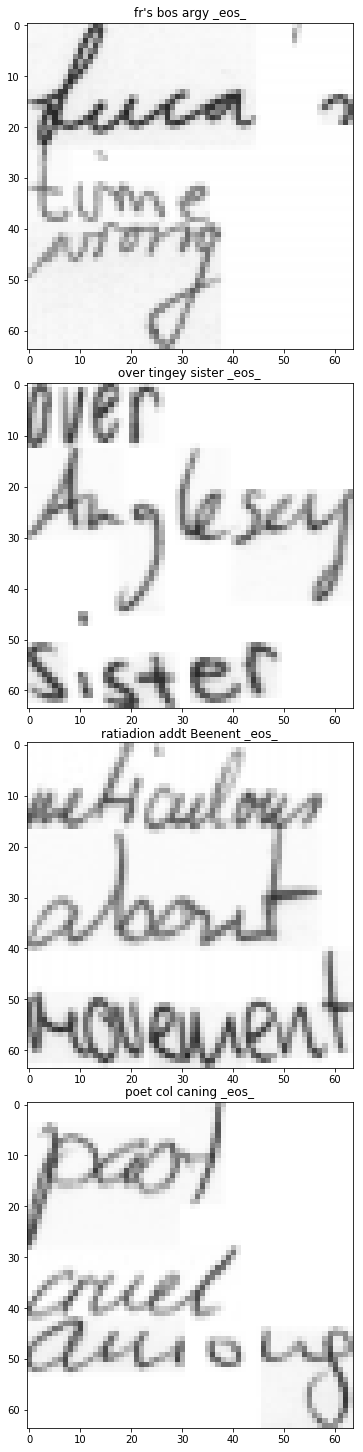

In [51]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    #t = label_text(y[i])     #=>  char indices
#     p = label_text(res[:,i])
    p = ctc_decode(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

### Attention

In [53]:
# use for arch
attns = attns.permute(2,0,1)

In [47]:
# conv
k = 32 #16
def torch_scale_attns(attns):
    bs,sl,_ = attns.shape
    num = sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [48]:
from scipy.ndimage import gaussian_filter

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [49]:
idx  = 12
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])

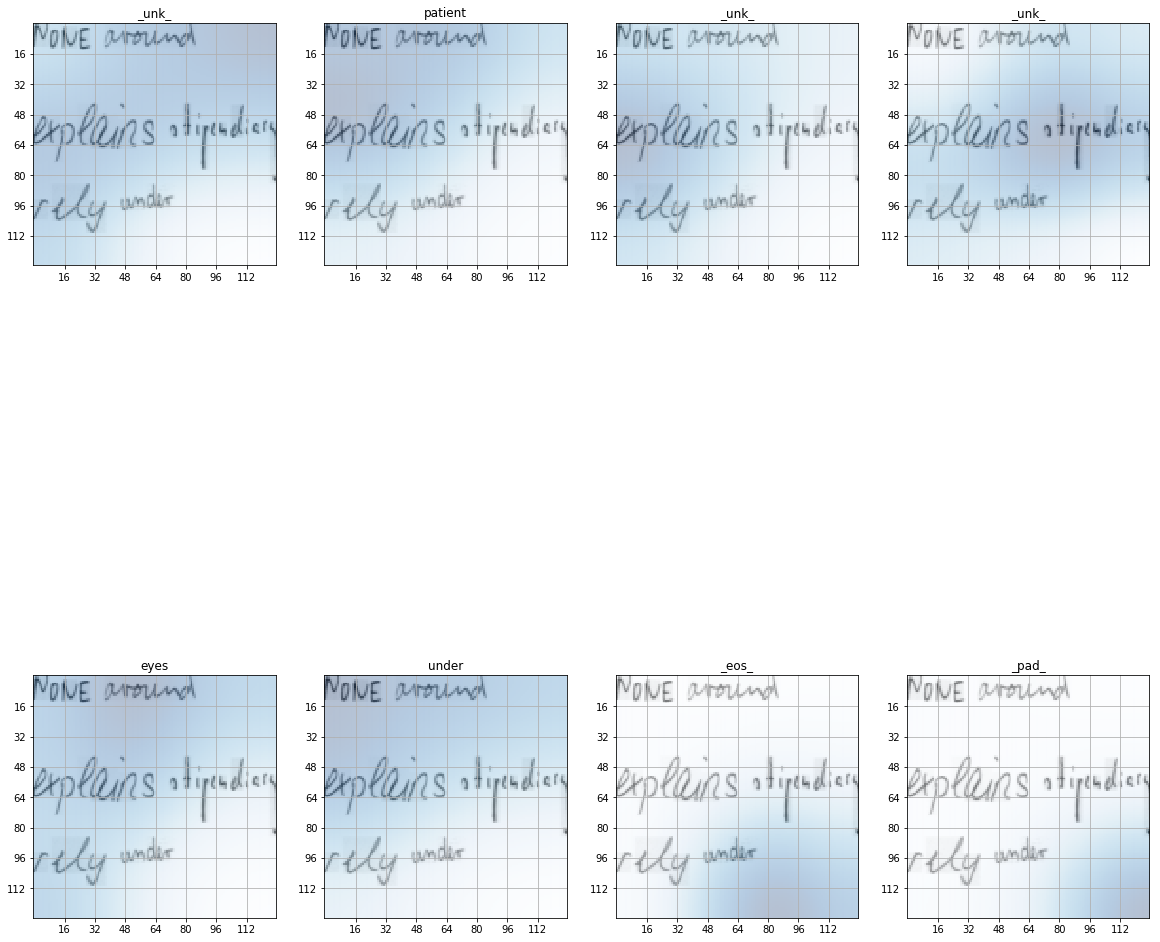

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(20, 20), gridspec_kw={'hspace': 0.5})
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(16, sz, 16)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

# Beam Search

In [86]:
idx=12

In [87]:
prob = preds[:, idx]
amts, idxs = torch.topk(prob[0], 5)
amts, idxs

(tensor([-18.0286, -20.7020, -21.7893, -21.8339, -22.1800],
        device='cuda:0', grad_fn=<TopkBackward>),
 tensor([  69,  121,    2, 1503,  456], device='cuda:0'))

In [88]:
[itos[i] for i in idxs]

['under', 'number', '_unk_', 'murder', 'winter']

In [77]:
word_stoi['deliberately']

3176

# Experiments

## MaxPool2d

In [20]:
pool = nn.MaxPool2d(2)

In [33]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
imgs = denorm(x)

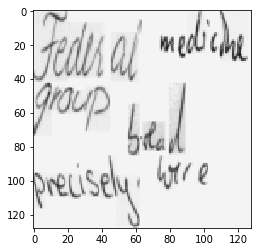

In [35]:
plt.imshow(imgs[0])

In [39]:
out = pool(x[0])

In [42]:
out_img = denorm(out[None])

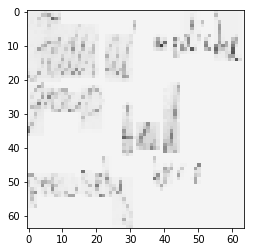

In [47]:
plt.imshow(out_img[0])